In [ ]:
import numpy as np
# test area
np.maximum.accumulate([1,2,3,1,5])


# Load Data

In [2]:
%matplotlib inline
import pandas
import numpy as np
from matplotlib import pyplot as plt

base = 10
threshold = 0.6

df = pandas.read_csv('d.csv', index_col=0)
# df = df.filter(regex='^[^\u4e00-\u9fa5]+$', axis=0)
a = df.iloc[:, :-1]
b = df.iloc[:, 1:]
b.columns = a.columns = range(df.shape[1] - 1)
r = (b - a) / a
p = 1 / np.linalg.norm(r, axis=1)
r = (r.T * p).T.values
l = r.shape[0]

correlation = np.ones([l, l])
for i in range(l):
    for j in range(i + 1, l):
        s = (r[i] * r[j]).sum()
        correlation[i][j] = s
        correlation[j][i] = s
correlation[np.abs(correlation) > threshold] = 0
correlation[np.logical_and(np.abs(correlation) <= threshold, correlation != 0)] = 1

d = np.concatenate((np.ones([r.shape[0], 1]) * base,
                        np.add.accumulate(r, axis=1) + np.ones(r.shape) * base), axis=1)

In [20]:
latest = np.load('lasttime.npy')
print(latest[0:3])
print(latest[-3:])
print(list(p[latest[0][0]]))

for a in latest:
    if 583 in a[0]:
        print(a)
        break

dict = {}
for a in latest:
    for b in a[0]:
        if b in dict:
            dict[b] += 1
        else:
            dict[b] = 1
x = []
for key in dict:
    x.append([key, dict[key]])
x = sorted(x, key=lambda m: m[1], reverse=True)

for y in x[:100]:
    print(df.index[y[0]], y[0], y[1])

for a in latest[0:10]:
    print(list(df.index[a[0]]), a[1],a[2],a[3])


[[list([9, 59, 88, 155, 350, 670]) 1.8056253588500415
  0.0018589784593572036 0.0010295482671671943]
 [list([9, 59, 502, 562, 640, 772]) 1.6299457287978325
  0.0016845617452476039 0.0010335078742100532]
 [list([59, 130, 178, 562, 772, 866]) 1.594335442877626
  0.0016413234794043527 0.0010294718634880986]]
[[list([9, 59, 378, 542, 770, 886]) 1.045005819299625
  0.0019315549179979516 0.0018483676189406312]
 [list([9, 88, 488, 502, 578, 774]) 1.04498521427709
  0.0019803316729576663 0.001895081046029574]
 [list([59, 86, 327, 514, 750, 907]) 1.0449299535353092
  0.002106996986814937 0.002016400218681012]]
[0.11966251614458838, 2.001318700001682, 3.20208237287235, 3.5636088784694033, 1.5596146960968076, 0.9586456777720503]
[list([9, 59, 562, 583, 670, 904]) 1.2353487928660043
 0.0017330470629933318 0.0014028807677649237]
PRA Health Sciences#PRAH 640 1707
新纪元能源#NEE 562 1695
慧俪轻体#WTW 907 1687
Ability Inc#ABIL 9 1658
大峡谷教育#LOPE 488 1558
Adobe#ADBE 16 1451
Arista Networks 59 1421
Regenxbio Inc#

# Test By tiger data

['哈里斯公司#HRS', '快验保#MED', '陌陌#MOMO', '英伟达#NVDA', '威瑞森#VZ', '慧俪轻体#WTW']
[[0. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0.]]
contribution: [1.29461054 1.         1.28918401 1.22320938 1.30570998 1.16184046]
percentage of total value: [30.64140268 12.35554146  8.59712582 12.66549206 26.91588822  8.82454975]
A,B 0.0018059183294547815 2.3079239099507194
revisit times:  36
max drawback 0.69% 10.25 10.32 10 9
average drop 0.0009727584617225035
12.263324388594294
111.0


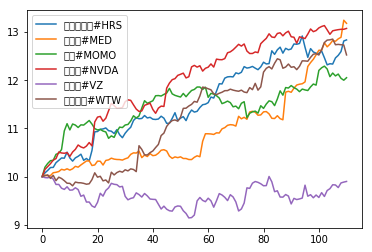

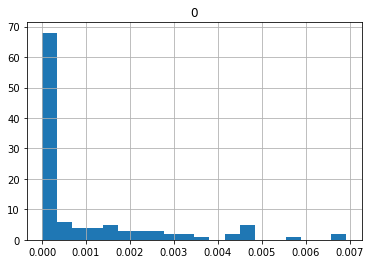

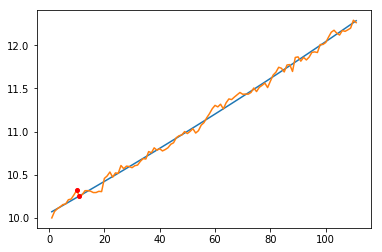

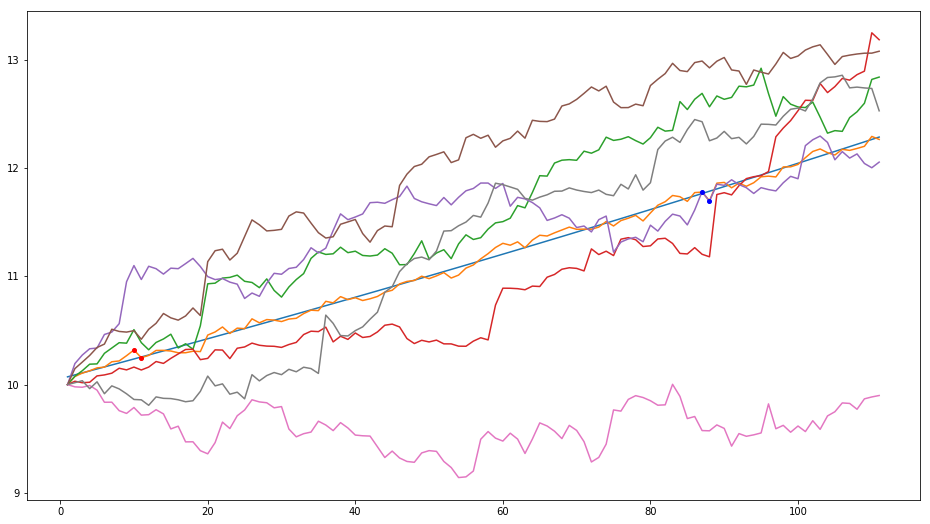

In [17]:
idx = [378, 514, 530, 583, 878, 907]
columns = list(np.array(df.index)[idx])
print(columns)

dates = df.columns.astype(np.float32)
startDate = dates[0]
dates = np.round((dates - startDate) / 3600 / 24 / 1000 / 7) + 1

coridx = np.zeros([len(idx), len(idx)])
for i in range(len(idx)):
    for j in range(i):
        coridx[i][j] = correlation[idx[i]][idx[j]]
        coridx[j][i] = correlation[idx[j]][idx[i]]
print(coridx)

# basic info
a = d[idx][:, 1:]
b = d[idx][:, :-1]
r = a - b
contri= np.abs(r).mean(axis=1)
contri = contri / contri.min()
print("contribution: {}".format(contri))

graph = pandas.DataFrame(d[idx]).T
graph.columns = columns 
graph.plot()


d[idx].sum(axis=0)[-1]

s = (d[idx]).sum(axis=0)
print("percentage of total value: {}".format(p[idx] / p[idx].sum() * 100))


# regression 
s = s / len(idx)
A, B = np.polyfit(dates, np.log(s), 1)
print('A,B', A, B)
y = np.exp(A * dates + B)
last = s[0] < y[0]
reg = 0
for i in range(1, len(s)):
    if (s[i] < y[i]) != last:
        reg += 1
        last = s[i] < y[i]
print('revisit times: ', reg)


# max drawback 
drop = 1 - s / np.maximum.accumulate(s)
drop_i = np.argsort(drop)
def getIJ(ij, i):
    return ij[i], np.argmax(s[:ij[i]])

i, j = getIJ(drop_i, -1)     
print('max drawback {:0.2f}% {:0.2f} {:0.2f} {} {}'.format(drop[i] * 100, s[i], s[j], i, j))
print('average drop', drop.mean())
pandas.DataFrame(drop).hist(bins=20)


print(s[-1])
print(dates[-1])

plt.figure()
plt.plot(dates, y)
plt.plot(dates, s)
plt.plot([i+1,j+1], [s[i], s[j]], 'o', color='Red', markersize=4)

plt.figure(figsize=(16,9))
plt.plot(dates, y)
plt.plot(dates, s)
plt.plot(dates, graph.values)
plt.plot([i+1,j+1], [s[i], s[j]], 'o', color='Red', markersize=4)

i2, j2 = getIJ(drop_i, -2)
plt.plot([i2+1,j2+1], [s[i2], s[j2]], 'o', color='Blue', markersize=4)



In [ ]:
d2 = pandas.read_csv('d2.csv', index_col=0)
a = d2.iloc[:, :-1]
b = d2.iloc[:, 1:]
print(a.shape)
print(b.shape)
b.columns = a.columns = range(d2.shape[1] - 1)
r = (b - a) / a
p = np.array([2.1325439640831663, 3.818926812574719, 3.2817522508432284, 2.967752013384421, 1.6536878786554772, 6.351134524200504])
r = (r.T[['欧特克', '美国电塔', '波音', 'F5网络', '美光科技', '标普500反向ETF']] * p).T.values

dates = d2.columns.astype(np.float32)
startDate = dates[0]
dates = np.round((dates - startDate) / 3600 / 24 / 1000 / 7) + 1

dd2 = np.concatenate((np.ones([r.shape[0], 1]) * base,
                        np.add.accumulate(r, axis=1) + np.ones(r.shape) * base), axis=1)

s = dd2.sum(axis=0)
print("percentage of total value: {}".format(p / p.sum() * 100))

# regression 
s = s / len(p)
A, B = np.polyfit(dates, np.log(s), 1)
print('A,B', A, B)
y = np.exp(A * dates + B)
last = s[0] < y[0]
reg = 0
for i in range(1, len(s)):
    if (s[i] < y[i]) != last:
        reg += 1
        last = s[i] < y[i]
print('revisit times: ', reg)


# max drawback 
drop = 1 - s / np.maximum.accumulate(s)
i = np.argmax(drop) # end of the period
j = np.argmax(s[:i]) # start of period
print('max drawback {:0.2f}% {:0.2f} {:0.2f} {} {}'.format(drop[i] * 100, s[i], s[j], i, j))
print('average drop', drop.mean())
pandas.DataFrame(drop).hist(bins=20)


print(s[-1])
print(dates[-1])

plt.figure()
plt.plot(dates, y)
plt.plot(dates, s)
plt.plot([i,j], [s[i], s[j]], 'o', color='Red', markersize=4)

# Test by yahoo data

In [ ]:
from glob import glob
df = None
for f in glob('sss\\*.csv'):
    name = f.split('\\')[1].split('.')[0]
    if df is None:
        df = pandas.read_csv(f, index_col=0)[['Adj Close']]
        df.columns = [name]
    else:
        csv = pandas.read_csv(f, index_col=0)[['Adj Close']]
        csv.columns = [name]
        df = pandas.concat([df,csv], axis=1)
        
df = df.dropna().T
print(df.shape)
a = df.iloc[:, :-1]
b = df.iloc[:, 1:]
b.columns = a.columns
r = (((b - a) / a).T * p[idx] ).T
r = np.concatenate((np.ones([r.shape[0], 1]) * base,
                    np.add.accumulate(r, axis=1) + np.ones(r.shape) * base), axis=1).T
r = pandas.DataFrame(r)
r.index = df.columns.astype(np.datetime64)
r.columns = df.index
r.plot(figsize=(16, 9))
print(r.shape)

y2 = r.sum(axis=1)
#plt.figure(figsize=(16, 9))
plt.plot(df.columns.astype(np.datetime64), y2 / len(idx))


# Test random output distribution

In [ ]:
import random
import dao

dist = []
n = 6
for i in range(500000):
    choice = random.sample(range(d.shape[0]), n)
    bad = True
    while bad:
        bad = False
        for k in range(len(choice)):
            for l in range(k):
                if np.abs(correlation[choice[k]][choice[l]]) == 0:
                    bad = True
                    break
            if bad:
                break
        if bad:
            choice = random.sample(range(d.shape[0]), n)

    result = dao.test_choice(choice)
    dist.append(result[1])
    
pandas.DataFrame(dist).hist(bins=1000)
pandas.qcut(dist,  [0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.999, 1])

# Load Weekly data and clean into d.csv

In [2]:
%matplotlib inline
import pandas
from glob import glob
import numpy as np

df = None
for f in glob('D:\\work\\main\\IB\\csv\\*_week.csv'):
    if df is None:
        df = pandas.read_csv(f, index_col=0).T
    else:
        df = pandas.concat([df,pandas.read_csv(f, index_col=0).T], axis=1)

d = df.iloc[-112:-1,:]
d = d.dropna(axis=1,how='any').astype('float32').T
print(d.shape)
d.to_csv('d2.csv')

c:\users\peter\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  # This is added back by InteractiveShellApp.init_path()


(952, 111)


# Load Daily data

In [ ]:
from glob import glob
%matplotlib inline
import pandas
import numpy as np
from matplotlib import pyplot as plt

daily = None
for f in glob('D:\\work\\main\\IB\\*_day.csv'):
    if daily is None:
        daily = pandas.read_csv(f, index_col=0).T
    else:
        daily = pandas.concat([daily,pandas.read_csv(f, index_col=0).T], axis=1)
daily.to_csv('day.csv')

# Test by day data

In [ ]:
from glob import glob
daily = pandas.read_csv('day.csv', index_col=0)[columns].T
print(columns)
moneyNeeded = 100 / (p[idx]/p[idx].sum()/daily.T.iloc[-1,:].values)[2]
tobuy = np.round(moneyNeeded * p[idx]/p[idx].sum() /  daily.T.iloc[-1,:].values)
moneyNeeded = tobuy * daily.T.iloc[-1,:].values
print('shares ', str(tobuy), tobuy.sum(), moneyNeeded)
moneyNeeded = moneyNeeded.sum()
print(moneyNeeded)

a = daily.iloc[:, :-1]
b = daily.iloc[:, 1:]
a.columns = b.columns
r = ((b / a - 1).T * p[idx] ).T
print(r.shape)

dates = daily.columns.astype(np.float32)
dates = np.round((dates - startDate) / 3600 / 24 / 1000) / 7 + 1
base = 10.4
r = np.concatenate((np.ones([r.shape[0], 1]) * base,
                    np.add.accumulate(r, axis=1) + np.ones(r.shape) * base), axis=1).T
r = pandas.DataFrame(r)
r.columns = columns
r.index = dates
r.plot(figsize=(16,9))

y = np.exp(A * dates + B) * moneyNeeded / 10
y2 = r.sum(axis=1) / len(columns) * moneyNeeded / 10
plt.figure(figsize=(16,9))
plt.plot(dates, y)
plt.plot(dates, y2)
#plt.plot(111, np.exp(A * 111 + B), marker='o', color='r', ls='')
#y2[-1] / y[-1] - 1